## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [2]:
import os
import keras
import warnings
warnings.filterwarnings('ignore')

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.25, 0.1]
redice_lr_patient = [5, 10, 15]

In [9]:
import itertools
from keras.callbacks import ReduceLROnPlateau
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                 min_lr=1e-12,
                                 monitor='val_loss',
                                 patience=reduce_patient,
                                 verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_______________________________________________________________

50000/50000 [==============================] - 2s 45us/step - loss: 1.6382 - acc: 0.4245 - val_loss: 1.7080 - val_acc: 0.4149
Epoch 4/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5624 - acc: 0.4509 - val_loss: 1.6165 - val_acc: 0.4337
Epoch 5/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5077 - acc: 0.4701 - val_loss: 1.5853 - val_acc: 0.4468
Epoch 6/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.4649 - acc: 0.4861 - val_loss: 1.5758 - val_acc: 0.4512
Epoch 7/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4271 - acc: 0.5011 - val_loss: 1.5365 - val_acc: 0.4611
Epoch 8/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.3927 - acc: 0.5135 - val_loss: 1.5217 - val_acc: 0.4673
Epoch 9/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.3636 - acc: 0.5224 - val_loss: 1.5068 - val_acc: 0.4736
Epoch 10/25
50000/50000 [===========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.2823 - acc: 0.2564 - val_loss: 2.3009 - val_acc: 0.2940
Epoch 2/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.7858 - acc: 0.3775 - val_loss: 1.9205 - val_acc: 0.3569
Epoch 3/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.6552 - acc: 0.4219 - val_loss: 1.7203 - val_acc: 0.4015
Epoch 4/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5796 - acc: 0.4483 - val_loss: 1.6539 - val_acc: 0.4217
Epoch 5/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5262 - acc: 0.4662 - val_loss: 1.6320 - val_acc: 0.4273
Epoch 6/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4836 - acc: 0.4811 - val_loss: 1.5890 - val_acc: 0.4421
Epoch 7/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.4434 - acc: 0.4962 - val_loss: 1.5721 - val_acc

50000/50000 [==============================] - 2s 45us/step - loss: 1.0682 - acc: 0.6365 - val_loss: 1.4429 - val_acc: 0.4928
Epoch 25/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.0540 - acc: 0.6407 - val_loss: 1.4530 - val_acc: 0.4955
Numbers of exp: 5, reduce_factor: 0.25, reduce_patient: 15
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________


50000/50000 [==============================] - 2s 47us/step - loss: 1.3133 - acc: 0.5425 - val_loss: 1.5127 - val_acc: 0.4651
Epoch 12/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.2894 - acc: 0.5524 - val_loss: 1.4941 - val_acc: 0.4745
Epoch 13/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.2674 - acc: 0.5613 - val_loss: 1.4760 - val_acc: 0.4796
Epoch 14/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.2461 - acc: 0.5678 - val_loss: 1.4772 - val_acc: 0.4783
Epoch 15/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.2251 - acc: 0.5754 - val_loss: 1.4631 - val_acc: 0.4857
Epoch 16/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.2071 - acc: 0.5835 - val_loss: 1.4712 - val_acc: 0.4836
Epoch 17/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.1871 - acc: 0.5902 - val_loss: 1.4645 - val_acc: 0.4834
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 75us/step - loss: 2.2645 - acc: 0.2579 - val_loss: 2.1323 - val_acc: 0.2992
Epoch 2/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.7685 - acc: 0.3835 - val_loss: 1.8224 - val_acc: 0.3714
Epoch 3/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.6401 - acc: 0.4240 - val_loss: 1.6958 - val_acc: 0.4090
Epoch 4/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5657 - acc: 0.4508 - val_loss: 1.6415 - val_acc: 0.4202
Epoch 5/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5129 - acc: 0.4680 - val_loss: 1.5960 - val_acc: 0.4348
Epoch 6/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4695 - acc: 0.4838 - val_loss: 1.5580 - val_acc: 0.4514
Epoch 7/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4317 - acc: 0.4979 - val_loss: 1.5353 - val_acc

Epoch 23/25
50000/50000 [==============================] - 2s 48us/step - loss: 0.4448 - acc: 0.8687 - val_loss: 1.5857 - val_acc: 0.5159

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 24/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.4016 - acc: 0.8889 - val_loss: 1.5523 - val_acc: 0.5228
Epoch 25/25
50000/50000 [==============================] - 3s 50us/step - loss: 0.3867 - acc: 0.8959 - val_loss: 1.5714 - val_acc: 0.5271
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 10
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (N

Epoch 10/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.0598 - acc: 0.6348 - val_loss: 1.4358 - val_acc: 0.4887
Epoch 11/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.0284 - acc: 0.6476 - val_loss: 1.5244 - val_acc: 0.4656
Epoch 12/25
50000/50000 [==============================] - 2s 47us/step - loss: 0.9987 - acc: 0.6566 - val_loss: 1.5180 - val_acc: 0.4677
Epoch 13/25
50000/50000 [==============================] - 2s 47us/step - loss: 0.9707 - acc: 0.6691 - val_loss: 1.4802 - val_acc: 0.4887
Epoch 14/25
50000/50000 [==============================] - 2s 47us/step - loss: 0.9402 - acc: 0.6818 - val_loss: 1.4930 - val_acc: 0.4918
Epoch 15/25
50000/50000 [==============================] - 2s 47us/step - loss: 0.9156 - acc: 0.6914 - val_loss: 1.4087 - val_acc: 0.5133
Epoch 16/25
50000/50000 [==============================] - 2s 47us/step - loss: 0.8916 - acc: 0.7004 - val_loss: 1.4669 - val_acc: 0.4996
Epoch 17/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 97us/step - loss: 2.0188 - acc: 0.3210 - val_loss: 1.9811 - val_acc: 0.3499
Epoch 2/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.6357 - acc: 0.4287 - val_loss: 1.7213 - val_acc: 0.4018
Epoch 3/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5451 - acc: 0.4612 - val_loss: 1.6301 - val_acc: 0.4315
Epoch 4/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.4880 - acc: 0.4828 - val_loss: 1.6102 - val_acc: 0.4321
Epoch 5/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.4428 - acc: 0.4987 - val_loss: 1.6141 - val_acc: 0.4336
Epoch 6/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4053 - acc: 0.5108 - val_loss: 1.5831 - val_acc: 0.4449
Epoch 7/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3760 - acc: 0.5235 - val_loss: 1.5347 - val_acc

50000/50000 [==============================] - 2s 47us/step - loss: 1.0559 - acc: 0.6429 - val_loss: 1.4443 - val_acc: 0.4953
Epoch 25/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.0453 - acc: 0.6458 - val_loss: 1.4374 - val_acc: 0.4965
Numbers of exp: 15, reduce_factor: 0.10, reduce_patient: 5
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________

50000/50000 [==============================] - 3s 57us/step - loss: 1.2727 - acc: 0.5599 - val_loss: 1.4755 - val_acc: 0.4775
Epoch 12/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.2528 - acc: 0.5663 - val_loss: 1.4702 - val_acc: 0.4843
Epoch 13/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2343 - acc: 0.5727 - val_loss: 1.4528 - val_acc: 0.4846
Epoch 14/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2176 - acc: 0.5796 - val_loss: 1.4614 - val_acc: 0.4833
Epoch 15/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.2020 - acc: 0.5859 - val_loss: 1.4627 - val_acc: 0.4845
Epoch 16/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1874 - acc: 0.5899 - val_loss: 1.4519 - val_acc: 0.4849
Epoch 17/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1717 - acc: 0.5989 - val_loss: 1.4498 - val_acc: 0.4872
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.8491 - acc: 0.3635 - val_loss: 1.9439 - val_acc: 0.3619
Epoch 2/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.5436 - acc: 0.4549 - val_loss: 2.2435 - val_acc: 0.2923
Epoch 3/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.4351 - acc: 0.4926 - val_loss: 2.1519 - val_acc: 0.2913
Epoch 4/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3429 - acc: 0.5259 - val_loss: 2.0507 - val_acc: 0.3471
Epoch 5/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2770 - acc: 0.5496 - val_loss: 1.6872 - val_acc: 0.4113
Epoch 6/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.2248 - acc: 0.5679 - val_loss: 2.1896 - val_acc: 0.3419
Epoch 7/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1763 - acc: 0.5845 - val_loss: 1.9751 - val_ac

50000/50000 [==============================] - 3s 57us/step - loss: 0.8882 - acc: 0.7031 - val_loss: 1.6035 - val_acc: 0.4680
Epoch 23/25
50000/50000 [==============================] - 3s 56us/step - loss: 0.8641 - acc: 0.7130 - val_loss: 1.6518 - val_acc: 0.4604
Epoch 24/25
50000/50000 [==============================] - 3s 55us/step - loss: 0.8469 - acc: 0.7176 - val_loss: 1.6951 - val_acc: 0.4510
Epoch 25/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.8284 - acc: 0.7262 - val_loss: 1.6392 - val_acc: 0.4642
Numbers of exp: 20, reduce_factor: 0.50, reduce_patient: 15
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
____________________________________________________

50000/50000 [==============================] - 3s 56us/step - loss: 1.2190 - acc: 0.5754 - val_loss: 1.5254 - val_acc: 0.4661
Epoch 10/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1890 - acc: 0.5869 - val_loss: 1.5502 - val_acc: 0.4618
Epoch 11/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1597 - acc: 0.5992 - val_loss: 1.5708 - val_acc: 0.4555
Epoch 12/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1311 - acc: 0.6102 - val_loss: 1.5665 - val_acc: 0.4552
Epoch 13/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1034 - acc: 0.6200 - val_loss: 1.8770 - val_acc: 0.3779
Epoch 14/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.0810 - acc: 0.6283 - val_loss: 1.5874 - val_acc: 0.4422

Epoch 00014: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 15/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.0116 - acc: 0.6584 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 145us/step - loss: 2.2637 - acc: 0.2562 - val_loss: 2.1447 - val_acc: 0.3006
Epoch 2/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.9197 - acc: 0.3419 - val_loss: 1.9433 - val_acc: 0.350292 
Epoch 3/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.7848 - acc: 0.3791 - val_loss: 1.8482 - val_acc: 0.3737
Epoch 4/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.7009 - acc: 0.4084 - val_loss: 1.7804 - val_acc: 0.3873
Epoch 5/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.6388 - acc: 0.4278 - val_loss: 1.7463 - val_acc: 0.3947
Epoch 6/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5894 - acc: 0.4437 - val_loss: 1.6916 - val_acc: 0.4119
Epoch 7/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.5474 - acc: 0.4587 - val_loss: 1.6598 - val

50000/50000 [==============================] - 3s 62us/step - loss: 1.2144 - acc: 0.5822 - val_loss: 1.4974 - val_acc: 0.4766
Epoch 25/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2007 - acc: 0.5880 - val_loss: 1.4959 - val_acc: 0.4741
Numbers of exp: 25, reduce_factor: 0.10, reduce_patient: 10
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
________________________________________________________________

50000/50000 [==============================] - 3s 53us/step - loss: 1.4287 - acc: 0.4990 - val_loss: 1.5986 - val_acc: 0.4446
Epoch 12/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.4034 - acc: 0.5091 - val_loss: 1.5897 - val_acc: 0.4499
Epoch 13/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.3805 - acc: 0.5176 - val_loss: 1.5850 - val_acc: 0.4494
Epoch 14/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.3605 - acc: 0.5257 - val_loss: 1.5720 - val_acc: 0.4541
Epoch 15/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3408 - acc: 0.5322 - val_loss: 1.5589 - val_acc: 0.4569
Epoch 16/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.3224 - acc: 0.5391 - val_loss: 1.5557 - val_acc: 0.4581
Epoch 17/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.3054 - acc: 0.5449 - val_loss: 1.5547 - val_acc: 0.4570
Epoch 18/25
50000/50000 [=====================

NUM_COLORS 27


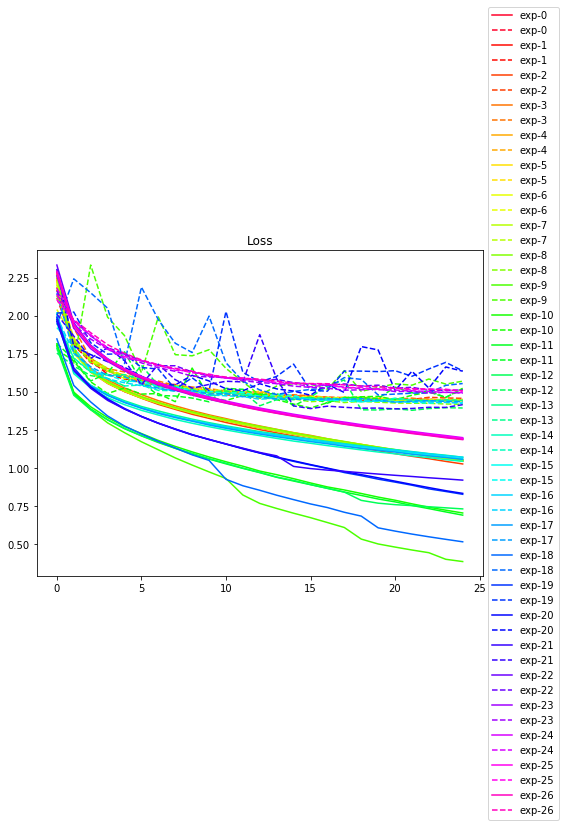

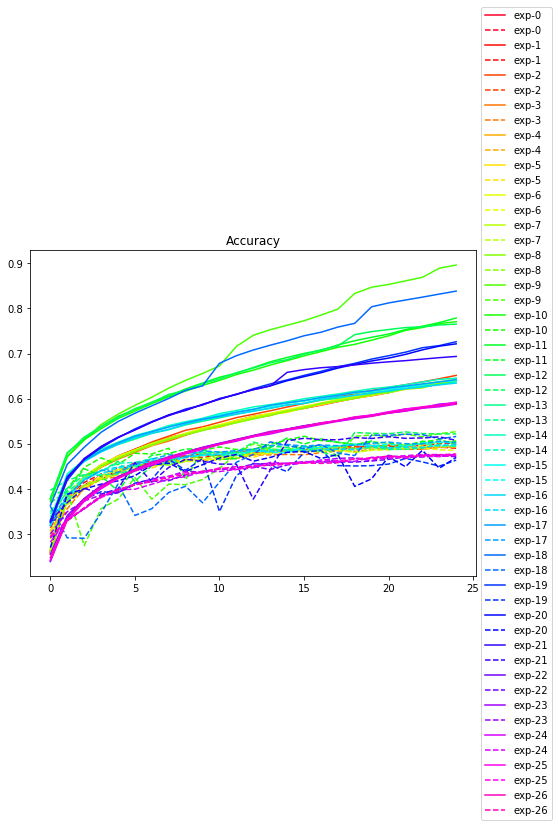

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())
print("NUM_COLORS %s" %NUM_COLORS)

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()